In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import platform

In [2]:
tf.__version__

'2.10.0'

### Data Preprocessing

#### Data download

In [3]:
if platform.platform()[:3].lower() == 'win':
    cache_subdir = 'D:/workspace/Pycharm/tf25/dataset/'
elif platform.platform()[:3].lower() == 'mac':
    cache_subdir = '/Users/rainyseason/winston/Workspace/python/Pycharm Project/tf25/cats_and_dogs/'

In [4]:
cache_subdir

'/Users/rainyseason/winston/Workspace/python/Pycharm Project/tf25/cats_and_dogs/'

In [5]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', 
                                      cache_subdir=cache_subdir, 
                                      origin=_URL, extract=True)

In [6]:
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

In [7]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

In [8]:
shuffle=True

In [9]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.
Metal device set to: Apple M1


2022-09-27 07:10:35.359374: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-27 07:10:35.359493: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                shuffle=shuffle,
                                                                batch_size=BATCH_SIZE,
                                                                image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


2022-09-27 07:10:35.436950: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


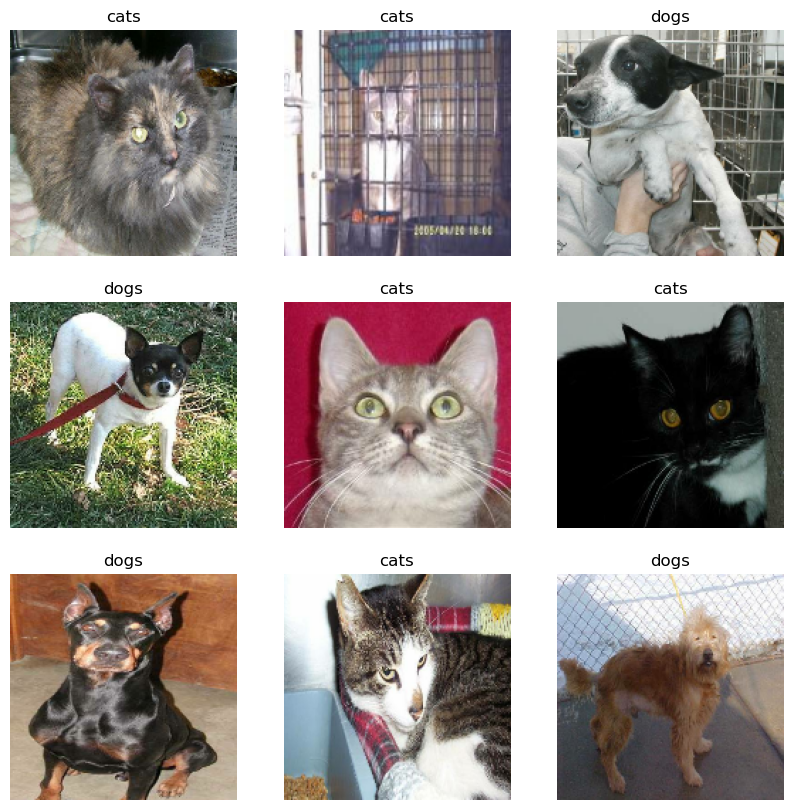

In [11]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i].numpy()])
        plt.axis('off')

In [12]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [13]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


#### Configure the dataset for performance

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

#### Use data augmentation

In [15]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
])

2022-09-27 07:10:36.405718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2022-09-27 07:10:36.676982: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2022-09-27 07:10:36.950402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2022-09-27 07:10:37.211702: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2022-09-27 07:10:37.469408: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2022-09-27 07:10:37.732420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2022-09-27 07:10:38.000595: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2022-09-27 07:10:38.256455: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2022-09-27 07:10:38.509257: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


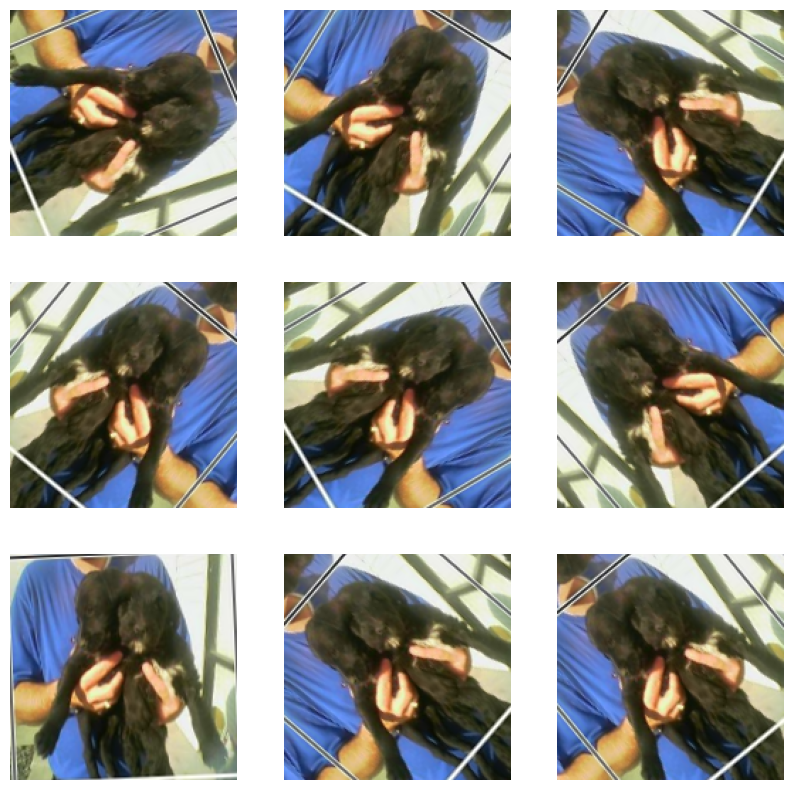

In [16]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

#### Rescale pixel values

In [17]:
for (a, b) in train_dataset.take(1):
    print(a[0][0][0])

tf.Tensor([135.4875 135.4875 109.4875], shape=(3,), dtype=float32)


In a moment, you will download tf.keras.applications.MobileNetV2 for use as your base model. This model expects pixel values in [-1, 1], but at this point, the pixel values in your images are in [0, 255]. To rescale them, use the preprocessing method included with the model.

In [18]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [19]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

### Create the base model from the pre-trained convnets

In [20]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3, )
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False, # block top classification layer for my training
                                              weights='imagenet')

In [21]:
for (a, b) in train_dataset.take(1):
    print(a.shape)
    a = base_model(a)
    print(a.shape)
    break

(32, 160, 160, 3)
(32, 5, 5, 1280)


In [22]:
image_batch, label_batch = next(iter(train_dataset))
print(image_batch.shape)
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 160, 160, 3)
(32, 5, 5, 1280)


### Feature extraction

In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

#### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's trainable flag to False will freeze all of them.

In [23]:
base_model.trainable = False

#### Important note about Batch Normalization layers

In [24]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 20, 20, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 20, 20, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 20, 20, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 20, 20, 32)  128         ['block_3_project[0][0]']        
 lization)

 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 10, 10, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 10, 10, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 10, 10, 384)  1536       ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_d

 block_10_project_BN (BatchNorm  (None, 10, 10, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 10, 10, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 10, 10, 576)  2304       ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 10, 10, 576)  0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_

                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 5, 5, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 5, 5, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 5, 5, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 5, 5, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
          

#### Add a classification head

In [25]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [26]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [27]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

#### Compile the model

In [28]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
             loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [29]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [30]:
len(model.trainable_variables)

2

#### Train the model

In [31]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

2022-09-27 07:10:40.792208: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


26/26 [==============================] - 2s 72ms/step - loss: 0.7610 - accuracy: 0.5470


In [32]:
print('initial loss: {:.2f}'.format(loss0))
print('initial accuracy: {:.2f}'.format(accuracy0))

initial loss: 0.76
initial accuracy: 0.55


In [33]:
history = model.fit(train_dataset,
                   epochs=initial_epochs,
                   validation_data=validation_dataset)

Epoch 1/10


2022-09-27 07:10:44.034529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 18s 268ms/step - loss: 0.7049 - accuracy: 0.5930 - val_loss: 0.5133 - val_accuracy: 0.7153
Epoch 2/10
63/63 [==============================] - 20s 320ms/step - loss: 0.5259 - accuracy: 0.7160 - val_loss: 0.3759 - val_accuracy: 0.8205
Epoch 3/10
63/63 [==============================] - 17s 271ms/step - loss: 0.4290 - accuracy: 0.7895 - val_loss: 0.2986 - val_accuracy: 0.8787
Epoch 4/10
63/63 [==============================] - 19s 303ms/step - loss: 0.3623 - accuracy: 0.8410 - val_loss: 0.2423 - val_accuracy: 0.9022
Epoch 5/10
63/63 [==============================] - 19s 299ms/step - loss: 0.3159 - accuracy: 0.8570 - val_loss: 0.2108 - val_accuracy: 0.9208
Epoch 6/10
63/63 [==============================] - 19s 303ms/step - loss: 0.2875 - accuracy: 0.8710 - val_loss: 0.1841 - val_accuracy: 0.9295
Epoch 7/10
63/63 [==============================] - 18s 278ms/step - loss: 0.2633 - accuracy: 0.8855 - val_loss: 0.1667 - val_accuracy: 0.9443
Epoch 8/10

#### Learning curves

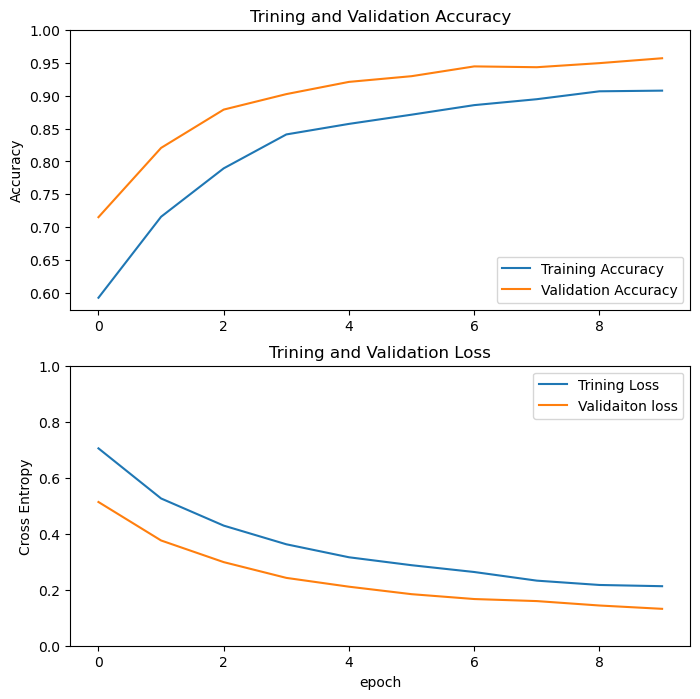

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Trining and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Trining Loss')
plt.plot(val_loss, label='Validaiton loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 1])
plt.title('Trining and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Fine tuning

#### Un-freeze the top layers of the model

In [35]:
base_model.trainable = True

In [36]:
# Let's take a look to see how many layers are in the base model
print('Number of layers in the base mdoel: ', len(base_model.layers))

Number of layers in the base mdoel:  154


In [37]:
# Fine-tune from this layer onwards
fine_tune_at = 100

#Freeze all the layres before the 'fine_tune_at' layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

#### Compile the model

In [38]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
             optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
             metrics=['accuracy'])

In [39]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [40]:
len(model.trainable_variables)

56

#### Continue training the model

In [41]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         validation_data=validation_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1])

Epoch 10/20


2022-09-27 07:13:45.487199: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - ETA: 0s - loss: 0.1789 - accuracy: 0.9235

2022-09-27 07:14:04.785095: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 23s 313ms/step - loss: 0.1789 - accuracy: 0.9235 - val_loss: 0.0818 - val_accuracy: 0.9790
Epoch 11/20
63/63 [==============================] - 19s 302ms/step - loss: 0.1183 - accuracy: 0.9480 - val_loss: 0.0574 - val_accuracy: 0.9814
Epoch 12/20
63/63 [==============================] - 21s 330ms/step - loss: 0.0981 - accuracy: 0.9565 - val_loss: 0.0477 - val_accuracy: 0.9827
Epoch 13/20
63/63 [==============================] - 20s 315ms/step - loss: 0.0846 - accuracy: 0.9650 - val_loss: 0.0648 - val_accuracy: 0.9790
Epoch 14/20
63/63 [==============================] - 20s 315ms/step - loss: 0.0924 - accuracy: 0.9595 - val_loss: 0.0541 - val_accuracy: 0.9752
Epoch 15/20
63/63 [==============================] - 20s 309ms/step - loss: 0.0808 - accuracy: 0.9675 - val_loss: 0.0440 - val_accuracy: 0.9827
Epoch 16/20
63/63 [==============================] - 20s 310ms/step - loss: 0.0744 - accuracy: 0.9735 - val_loss: 0.0470 - val_accuracy: 0.9802
Epoc

In [43]:
print(acc)
print(len(acc))

[0.593000054359436, 0.7160000205039978, 0.7895000576972961, 0.8410000205039978, 0.8570000529289246, 0.8710000514984131, 0.8855000138282776, 0.8945000171661377, 0.9065000414848328, 0.9075000286102295]
10


In [57]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

In [60]:
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

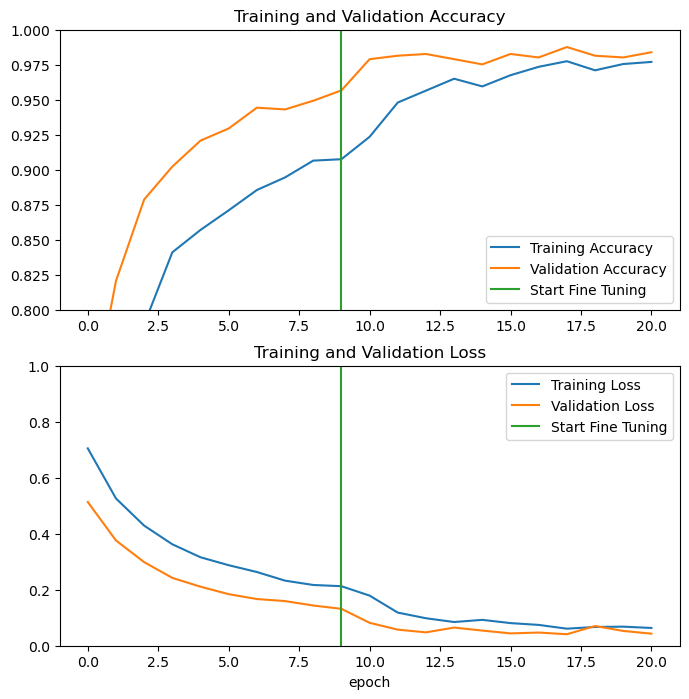

In [63]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim(0.8, 1)
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#### Evaluation and prediction